Test instances: 32


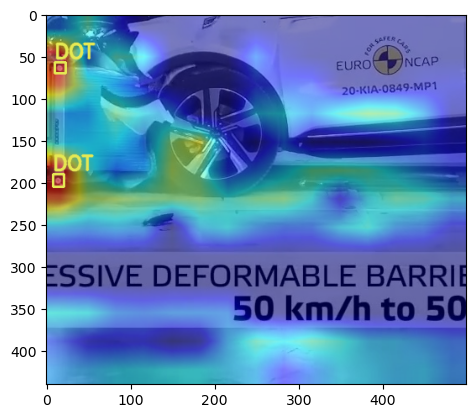

KeyboardInterrupt: 

In [2]:
import torch
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
import requests
import torchvision
from PIL import Image
import numpy as np
import config
import models
import glob
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose([T.ToTensor()])

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

def predict(input_tensor, model, detection_threshold):
    model.eval()
    outputs = model(input_tensor)
    pred_classes = [config.CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

# savepoint_loc = "/home/dan/FH/Paper/private/models/pytorch/faster_rcnn50/mxtdot/4/checkpoint.pth"
savepoint_loc = config.SAVEPOINT_LOC
# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(config.CLASSES), 3))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

model = models.create_faster_rcnn_resnet50_fpn(config.NUM_CLASSES)
model.load_state_dict(models.load_custom_rpn_savestate(savepoint_loc,device))
model.eval().to(device)

# target_layers = [model.backbone.body.layer4[-1]]
target_layers = [model.backbone]

test_dir = config.TEST_DIR_IMGS
test_images = glob.glob(f"{test_dir}/*")
print(f"Test instances: {len(test_images)}")

for i,img in enumerate(test_images):
    if i < 0:
        continue
    if i > 725:
        break

    image = Image.open(img)
    image_float_np = np.float32(image) / 255

    input_tensor = get_transform()(image)
    input_tensor = input_tensor.to(device)
    # Add a batch dimension:
    input_tensor = input_tensor.unsqueeze(0)

    boxes, classes, labels, indices = predict(input_tensor, model, 0.7)

    targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
    

    # cam = AblationCAM(model,
    #                   target_layers, 
    #                   use_cuda=False, 
    #                   reshape_transform=fasterrcnn_reshape_transform,
    #                   ablation_layer=AblationLayerFasterRCNN(),
    #                   ratio_channels_to_ablate=1.0)

    # or a very fast alternative:

    cam = EigenCAM(model,
                target_layers, 
                use_cuda=False, 
                reshape_transform=fasterrcnn_reshape_transform)

    grayscale_cam = cam(input_tensor, targets=targets)
    # # Take the first image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
    # # And lets draw the boxes again:
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
    plt.figure()
    plt.imshow(Image.fromarray(cam_image))
    plt.show()